In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [8]:
# looks weird, but makes pixel values between -1 and 1
# assume they are transformed from (0,1)
# min value = (0 - 0.5 mean) / 0.5 std = -1
# max value = (1 - 0.5) / 0.5 =  1

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,), std = (0.5,))
])

In [9]:
train_dataset = torchvision.datasets.MNIST(
    root='.', 
    train=True, 
    transform=transform, 
    download=True)

Using downloaded and verified file: .\MNIST\raw\train-images-idx3-ubyte.gz
Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw
Using downloaded and verified file: .\MNIST\raw\train-labels-idx1-ubyte.gz
Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw
Using downloaded and verified file: .\MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw


Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw
Processing...


E:\Comchem\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [10]:
len(train_dataset)

60000

In [11]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [12]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,1)
)

In [13]:
# Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256,512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512,1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [14]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [20]:
# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [21]:
# scale image back to (0, 1)
def scale_image(img):
  out = (img + 1) / 2
  return out

In [22]:
# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [24]:
# Training loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(200):
  for inputs, _ in data_loader:
    # don't need targets

    # reshape and move to GPU
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    # set ones and zeros to correct size
    ones = ones_[:n]
    zeros = zeros_[:n]

    ###########################
    ### Train discriminator ###
    ###########################

    # real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    # gradient descent step
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    #######################
    ### Train generator ###
    #######################

    # do it twice:
    for _ in range(2):
      # fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      # reverse the labels!
      g_loss = criterion(fake_outputs, ones)

      # gradient descent step
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    # save losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  ### print and save things ###
  print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

  # Pytorch has a function to save a batch of images to file
  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")






Epoch: 0, d_loss: 0.46018943190574646, g_loss: 1.5246623754501343
Epoch: 1, d_loss: 0.6469460725784302, g_loss: 0.39958083629608154
Epoch: 2, d_loss: 0.6912171840667725, g_loss: 0.9077358245849609
Epoch: 3, d_loss: 0.6311647891998291, g_loss: 0.9712885618209839
Epoch: 4, d_loss: 0.6553670167922974, g_loss: 0.763027548789978
Epoch: 5, d_loss: 0.6463959813117981, g_loss: 0.7844980955123901
Epoch: 6, d_loss: 0.6670425534248352, g_loss: 0.7227544784545898
Epoch: 7, d_loss: 0.6907176375389099, g_loss: 0.5159170627593994
Epoch: 8, d_loss: 0.6362186074256897, g_loss: 1.0156214237213135
Epoch: 9, d_loss: 0.6408945322036743, g_loss: 0.798439621925354
Epoch: 10, d_loss: 0.6939271092414856, g_loss: 0.8505196571350098
Epoch: 11, d_loss: 0.6700718998908997, g_loss: 1.159453272819519
Epoch: 12, d_loss: 0.70680171251297, g_loss: 1.4738439321517944
Epoch: 13, d_loss: 0.6479032039642334, g_loss: 0.8573469519615173
Epoch: 14, d_loss: 0.6216069459915161, g_loss: 1.0464537143707275
Epoch: 15, d_loss:

Epoch: 125, d_loss: 0.5600799918174744, g_loss: 1.4873170852661133
Epoch: 126, d_loss: 0.5258864164352417, g_loss: 1.6706905364990234
Epoch: 127, d_loss: 0.5715206861495972, g_loss: 1.7050979137420654
Epoch: 128, d_loss: 0.47946789860725403, g_loss: 1.245051383972168
Epoch: 129, d_loss: 0.5419245958328247, g_loss: 1.5713499784469604
Epoch: 130, d_loss: 0.5333428978919983, g_loss: 0.9694706797599792
Epoch: 131, d_loss: 0.5756856203079224, g_loss: 1.6548961400985718
Epoch: 132, d_loss: 0.5389693975448608, g_loss: 1.1617262363433838
Epoch: 133, d_loss: 0.5636047124862671, g_loss: 1.0555670261383057
Epoch: 134, d_loss: 0.5813964009284973, g_loss: 1.6343650817871094
Epoch: 135, d_loss: 0.5681804418563843, g_loss: 1.5831162929534912
Epoch: 136, d_loss: 0.4968589246273041, g_loss: 1.2823834419250488
Epoch: 137, d_loss: 0.5403105020523071, g_loss: 1.5559924840927124
Epoch: 138, d_loss: 0.5524773001670837, g_loss: 0.783881664276123
Epoch: 139, d_loss: 0.5844336748123169, g_loss: 1.2148864269256

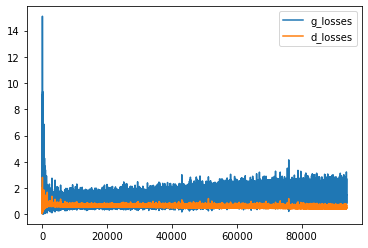

In [25]:
plt.plot(g_losses, label = 'g_losses')
plt.plot(d_losses, label = 'd_losses')
plt.legend()

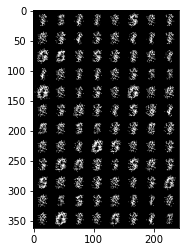

In [26]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)

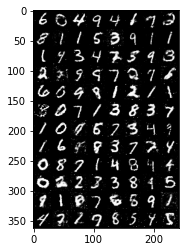

In [27]:
a = imread('gan_images/50.png')
plt.imshow(a)

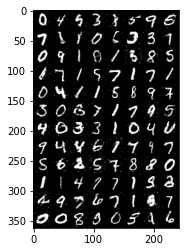

In [28]:
a = imread('gan_images/100.png')
plt.imshow(a)

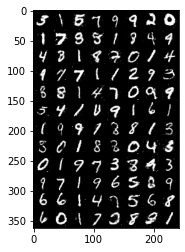

In [29]:
a = imread('gan_images/150.png')
plt.imshow(a)

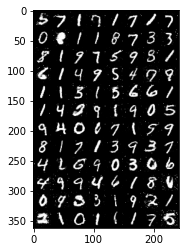

In [30]:
a = imread('gan_images/200.png')
plt.imshow(a)